# Gardens Marketplace

> Porting the [cadCAD bonding curve model](https://github.com/cadCAD-org/demos/blob/master/demos/Multiscale/bonding_curve/Bonding_Curve.ipynb) from the [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper into a Gardens cadCAD model.

## Bonding Curve Experiments

This demo is based off of Dr. Zargham's [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper. It's abstract is as follows:

Discrete event games are discrete time dynamical systems whose state transitions are discrete events caused by actions taken by agents within the game. The agents’ objectives and associated decision rules need not be known to the game designer in order to impose structure on a game’s reachable states. Mechanism design for discrete event games is accomplished by declaring desirable invariant properties and restricting the state transition functions to conserve these properties at every point in time for all admissible actions and for all agents, using techniques familiar from state-feedback control theory. Building upon these connections to control theory, a framework is developed to equip these games with estimation properties of signals which are private to the agents playing the game. Token bonding curves are presented as discrete event games and numerical experiments are used to investigate their signal processing properties with a focus on input-output response dynamics.

The whole paper is highly recommended and will enhance understanding of demo below. This notebook contains both experiments run in section 4, beginning page 14. The *Price Estimator Response Dynamics* section does not contain any monte carlo runs while *Price Estimator Response Dynamics Parameter Sweep* contains 10 monte carlo runs. Both have 4,000 timesteps.


## Model File structure
* Bonding_Curve.ipynb
* model - Price Estimator Response Dynamics simulations
* model_param - Price Estimator Response Dynamics Parameter Sweep simulations

In each model folder there exist 4 files and a parts folder (all links are for the model folder), the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), and [state_variables.py](state_variables.py). The [config.py](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [partial_state_update_block.py](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [state_variables.py](state_variables.py) defines the state variables and [run.py](model/run.py) actually runs the simulation. 

The components of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in the [utils.py](model/parts/utils.py).


## Price Estimator Response Dynamics 

To illustrate the impact on $P_t$ of different driving processes, three deterministic signals are defined: a Square-Wave, a Triangle-Wave and a Sine-Wave. To capture stochastic effects, a Martingale stochastic process is also introduced. These simple signals abstract away from the complexity of possible inputs $\hat P_t$, while simultaneously acting as a starting point for the analysis of a broad range of feedback mechanisms caused by a closed-loop game. The determinstic signals can be characterized by wavelength $\lambda$, amplitude $A$ and phase $\phi$, for time $t\in\{0,\ldots 4000\}$, and are described using the functional forms in Table 1.

Our experiments use the bonding curvature parameter $\kappa =2$ and the system is initialized with a community token supply $S_0=1000000$ and reserve currency units $R_0=50000$, resulting in an initial price $P_0=0.10$ reserve units per token and an invariant $\bar V=V_0=20000000$.  The deterministic driving functions are taken with $\phi=0$, $B=P_0$ and $\lambda =2000$. Amplitude $A$ takes values $\frac{P_0}{2}$, $\frac{P_0}{100}$, and $\frac{P_0}{2}$ for the Square-Wave, Triangle-Wave and Sine-Wave, respectively. For the Random Walk, an initial condition $\hat P_0 = P_0$ is applied, and the percent change in $\hat P_0$ is drawn from a Gaussian distribution with mean $\mu =0$ and variance $\sigma=0.05$.

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [108]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: pandas, funcy, fn, pathos
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

We're using [cadCAD Diagram](https://github.com/cadCAD-org/cadCAD_diagram), which is separate from cadCAD. If you're using the VS Code container from this repo it's already installed, but otherwise you might need to instal it.

In [109]:
# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Stuff
import numpy as np
import random as random
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import seaborn as sns

# Notebook setup
experiment = Experiment()
del configs[:]
%matplotlib inline


## Utility Functions

In [110]:
default_kappa= 2
default_exit_tax = .02

#value function for a given state (R,S)
def invariant(R,S,kappa=default_kappa):
    return (S**kappa)/R

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def reserve(S, V0, kappa=default_kappa):
    return (S**kappa)/V0

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def supply(R, V0, kappa=default_kappa):
    return (V0*R)**(1/kappa)

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return a spot price P as a function of reserve R
def spot_price(R, V0, kappa=default_kappa):
    return kappa*R**((kappa-1)/kappa)/V0**(1/kappa)

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#deposit deltaR to Mint deltaS
#with realized price deltaR/deltaS
def mint(deltaR, R,S, V0, kappa=default_kappa):
    deltaS = (V0*(R+deltaR))**(1/kappa)-S
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    return deltaS, realized_price

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#burn deltaS to Withdraw deltaR
#with realized price deltaR/deltaS
def withdraw(deltaS, R,S, V0, kappa=default_kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    return deltaR, realized_price

def withdraw_with_tax(deltaS, R,S, V0, exit_tax = default_exit_tax, kappa=default_kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    #print(deltaR)
    quantity_taxed = exit_tax*deltaR
    quantity_recieved = (1-exit_tax)*deltaR

    realized_price = quantity_recieved/deltaS

    return quantity_recieved, quantity_taxed, realized_price

def response_plot(rdf, title):
    plt.subplots(figsize=(10,6))
    ax1=plt.subplot(2,1,1)
    rdf[["spot_price","price"]].plot(ax=ax1)
    plt.legend(["spot price (output: $P_t$)", "price sample (input: $\hat P_t$)" ])
    plt.ylabel("Price, $\hat P_t$, $P_t$")
    plt.title(title+" Response Dynamics")
    ax2=plt.subplot(2,1,2)
    rdf[["abs_err"]].plot(ax=ax2,logy=True, color='green')
    plt.legend(["$Error: |P_t-\hat P_t|$" ])
    plt.xlabel("transaction count (time)")
    plt.ylabel("Absolute Value of Estimation Error")
    plt.show()


## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [111]:
hatch_raise = 100000 # fiat units
hatch_price = .1 # fiat per tokens
theta = .5 # share of funds going to funding pool at launch
kappa = 2 # bonding curvature parameter

sys_params = {
    'kappa': [kappa],
    'invariant': [invariant(R0,S0,kappa)],
    'dust' : [10**-8],
    'rule' : ['martin' for r in range(10)],
    'dP' : ['N/A' for r in range(10)],
    'sigma': [.1*(.5**(r+1)) for r in range(10)],
    'period': ['N/A' for r in range(10)],
    'phi': [0], # phi for exiting funds
    'beta': [0.9], # beta is param for armijo rule
}


In [112]:
genesis_states = {
    'supply': hatch_raise/hatch_price,
    'price': spot_price(R0, V0, kappa),
    'reserve': hatch_raise*(1-theta),
    'spot_price': spot_price(R0, V0, kappa),
    'output_price': spot_price(R0, V0, kappa),
}

params = {
    'M': sys_params, # system parameters
    'T': range(4000), # number of timesteps
    'N': 10 # number of monte carlo runs
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [113]:
# Behaviors
def set_action(params, step, sL, s):

    R = s['reserve']
    S = s['supply']
    V0 = params['invariant']
    P=s['spot_price']
    period = params['period']

    if params['rule'] == 'step':
        bump = int((s['timestep'] % int(period/2) == 0))*int(s['timestep']>0)
        sign = -(-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*bump*sign
    elif params['rule'] == 'ramp':
        sign = (-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*sign
    elif params['rule'] == 'sin':
        new_price = P + params['dP']*np.sin(2*np.pi*s['timestep']/period)
    elif params['rule']=='martin' :
        rv = np.random.normal(0, params['sigma'])
        new_price = s['price']+s['price']*rv
    else :
        new_price = s['price']

    if P>new_price:
        mech = 'burn'

        #approx for burn s.t. p=phat
        #armijo style
        amt = S*(1-params['dust'])

        def pbar(amt):
            output = withdraw(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return np.Infinity
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)< new_price:
                amt = amt*params['beta']

    else:
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = R*(1-params['dust'])

        def pbar(amt):
            output = mint(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return 0
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)> new_price:
                amt = amt*params['beta']

    action = {'mech':mech, 'amt':amt,'pin':new_price ,'pbar':pbar(amt),'posterior':{}}

    if action['mech'] == 'bond':
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        P = spot_price(R, V0, params['kappa'])

    elif action['mech'] == 'burn':
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        S = S-amt
        P = spot_price(R, V0, params['kappa'])

    action['posterior'] = {'S':S, 'R':R,'P':P}

    return {'action': action}



## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [114]:
# Mechanisms
def update_S(params, step, sL, s, _input):

    action = _input['action']
    S = action['posterior']['S']

    key = 'supply'
    value = S

    return (key, value)

def update_R(params, step, sL, s, _input):

    action = _input['action']
    R = action['posterior']['R']

    key = 'reserve'
    value = R

    return (key, value)

def update_P(params, step, sL, s, _input):

    action = _input['action']
    P = action['posterior']['P']

    key = 'spot_price'
    value = P

    return (key, value)

def update_Pbar(params, step, sL, s, _input):

    action = _input['action']
    pbar = action['pbar']

    key = 'output_price'
    value = pbar

    return (key, value)

def capture_Pin(params, step, sL, s, _input):

    Pin = _input['action']['pin']
    if Pin== 0:
        print(_input['action'])
    key = 'price'
    value = Pin

    return (key, value)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [115]:
partial_state_update_blocks = [
    {
      # system.py
      'policies': {
          'act': set_action,
        },
        'variables': {
            'supply': update_S,
            'reserve': update_R,
            'spot_price': update_P,
            'output_price': update_Pbar,
            'price': capture_Pin,
        }
    }
]

## Running the cadCAD Engine

In [116]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 10
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (4000, 9, 10, 5)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

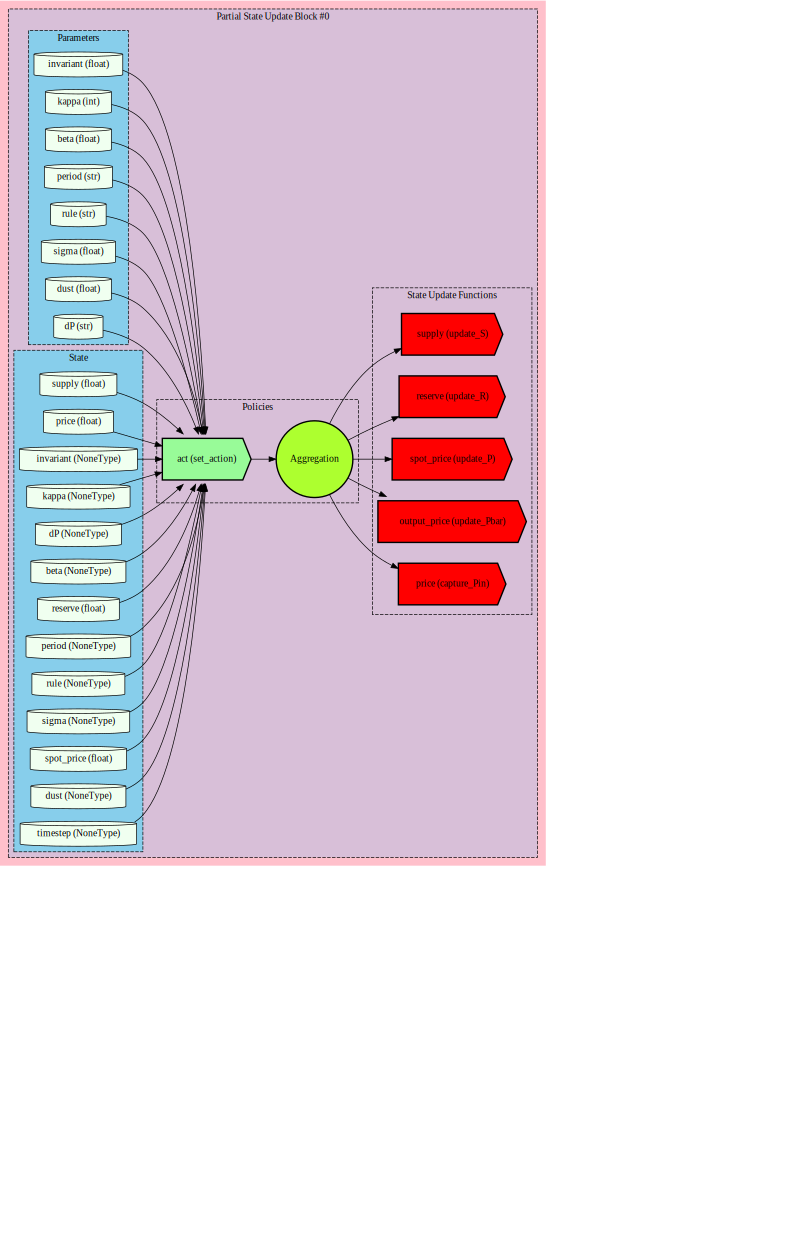

In [117]:
diagram_from_config(configs[0])

In [118]:
# Result System Events DataFrame
df = pd.DataFrame(raw_system_events)

def postprocessing(df):
    # Clean substeps
    first_ind = (df.substep == 0) & (df.timestep == 0)
    last_ind = df.substep == max(df.substep)
    inds_to_drop = (first_ind | last_ind)
    df = df.loc[inds_to_drop].drop(columns=['substep'])

    # Attribute parameters to each row
    df = df.assign(**configs[0].sim_config['M'])
    for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
        df.loc[n_df.index] = n_df.assign(**configs[i].sim_config['M'])

    df['err'] = df.price-df.spot_price
    df['abs_err']= df.err.apply(abs)
    df['rel_err'] = df.abs_err/df.spot_price

    return df

rdf = postprocessing(df)

In [119]:
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

supply     price       reserve  spot_price  \
subset run timestep substep                                                     
0      1   0        0        1.000000e+06  0.100000  50000.000000    0.100000   
           1        1        1.023280e+06  0.101164  52355.064325    0.102328   
           2        1        9.916571e+05  0.100703  49169.190431    0.099166   
           3        1        1.044502e+06  0.101976  54549.233491    0.104450   
           4        1        1.030607e+06  0.103692  53107.572272    0.103061   
...                                   ...       ...           ...         ...   
9      10  3996     1        1.012733e+06  0.101303  51281.366491    0.101273   
           3997     1        1.013743e+06  0.101325  51383.758872    0.101374   
           3998     1        1.013108e+06  0.101340  51319.387103    0.101311   
           3999     1        1.013845e+06  0.101349  51394.086491    0.101385   
           4000     1        1.013210e+06  0.101350  51329.701784    0.101321   

                             output_price  simulation  
subset run timestep substep                            
0      1   0        0            0.100000           0  
           1        1            0.101164           0  
           2        1            0.100747           0  
           3        1            0.101808           0  
           4        1            0.103755           0  
...                                   ...         ...  
9      10  3996     1            0.101305           9  
           3997     1            0.101324           9  
           3998     1            0.101343           9  
           3999     1            0.101348           9  
           4000     1            0.101353           9  

[400100 rows x 6 columns]

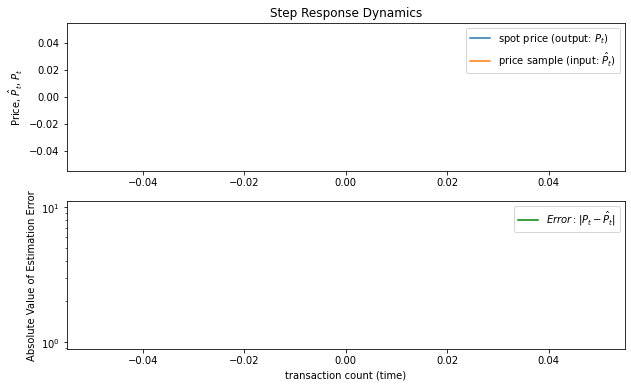

In [120]:
response_plot(rdf[rdf.rule=='step'], "Step")

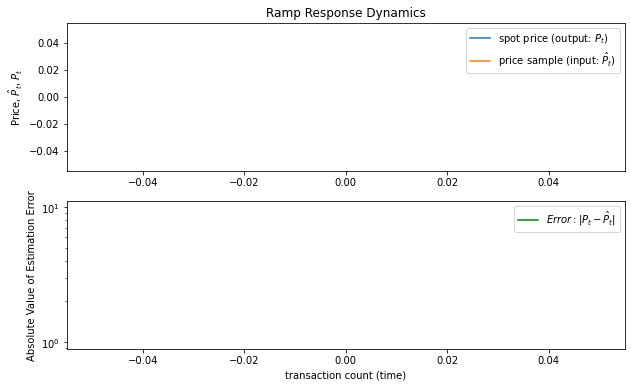

In [121]:
response_plot(rdf[rdf.rule=='ramp'], "Ramp")

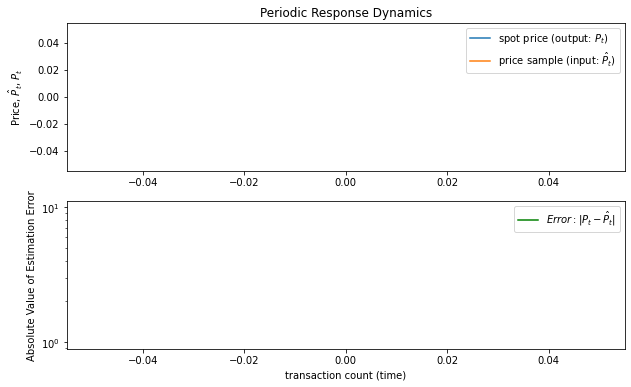

In [122]:
response_plot(rdf[rdf.rule=='sin'], "Periodic")

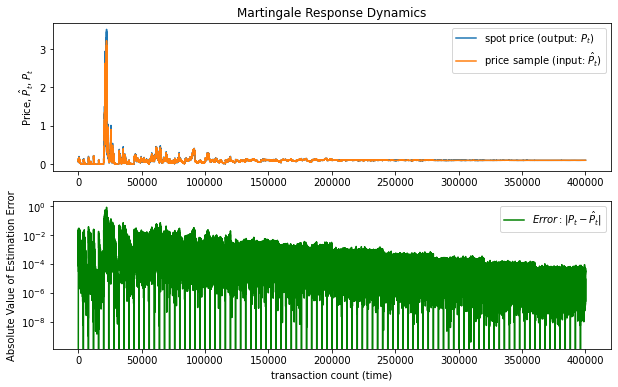

In [123]:
response_plot(rdf[rdf.rule=='martin'], "Martingale")

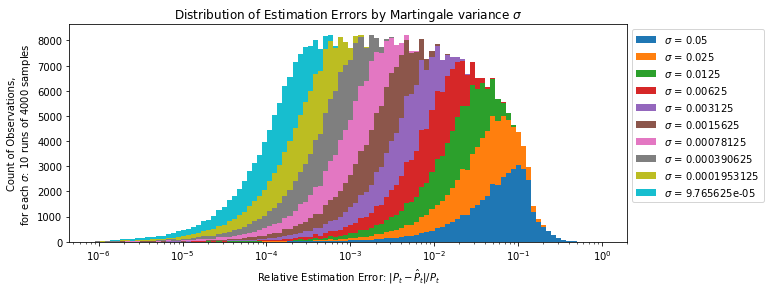

In [124]:
sigs = sys_params['sigma']

sig_data= [rdf[rdf.sigma == sig ].abs_err for sig in sigs]
rdf['rel_err'] = rdf.abs_err/rdf.spot_price

sig_data2= [rdf[rdf.sigma == sig ].rel_err for sig in sigs]

plt.subplots(figsize=(10,4))
plt.hist(sig_data2, bins=[.87**pow for pow in range(100,-1,-1)], stacked=True)
plt.xscale("log")
plt.legend(['$\sigma$ = '+str(st) for st in sys_params['sigma']], bbox_to_anchor=(1, 1), loc='upper left', ncol=1 )

plt.title('Distribution of Estimation Errors by Martingale variance $\sigma$')
plt.ylabel("""Count of Observations,
for each $\sigma$: 10 runs of 4000 samples """)
plt.xlabel('Relative Estimation Error: $|P_t - \hat P_t|/P_t$')
plt.show()

## Conclusion

In this notebook, we have shared the experimental code used by Dr. Zargham's [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper. We have illustrated how to use different driving processes for running numerical simulations.